# Final Project

### 獲取歷史資料

In [57]:
from finlab.data import Data
import talib
import pandas as pd

data = Data()

rev = data.get("當月營收")
close = data.get("收盤價")
vol = data.get('成交金額')
low = data.get('最低價')
high = data.get('最高價')

compare_rev = data.get("上月比較增減(%)")

# rev.index = rev.index.shift(5, "d")

               Price    Return       MA2
date                                    
2007-05-10  0.047332  0.087425  0.077826
2007-07-10  0.053356  0.109129  0.100268
2007-08-10  0.035284  0.137082  0.114215
2007-09-10  0.034768  0.140522  0.129230
2007-12-10  0.034596  0.148024  0.144057


<AxesSubplot:xlabel='date'>

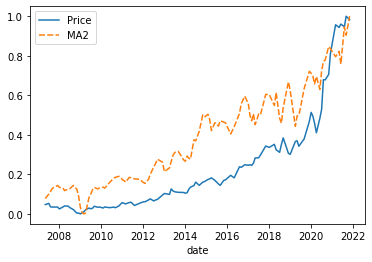

In [69]:
from sklearn.preprocessing import MinMaxScaler
sid = '2330'

# 月營收
return_2330 = rev[sid].to_frame().reset_index()
# 月增減，看起來只是雜訊
# return_2330 = compare_rev[sid].to_frame().reset_index()
return_2330['MA2'] = return_2330[sid].rolling(window=2).mean()
close_2330 = close[sid].to_frame().reset_index()

result_df = close_2330.merge(return_2330,on="date", how="inner")
result_df.set_index("date" , inplace=True)
scaler = MinMaxScaler()
price_name = sid + '_x'
return_name = sid + '_y'
result_df[[price_name, return_name, 'MA2']] = scaler.fit_transform(result_df[[price_name, return_name, 'MA2']])
result_df.rename(columns={price_name: 'Price', 
                           return_name: 'Return'}, inplace=True)
print(result_df.head())

import seaborn as sns
sns.lineplot(data=result_df[['Price', 'MA2']])

In [89]:
sid_list = list(high.columns)
def getAtrRatio(period, sid):
  """
      平均波動率：ATR(14)/MA(14)
  """
  atr = talib.ATR(high[sid], low[sid], close[sid], timeperiod=period)
  ma = talib.MA(close[sid], timeperiod=period)

  volatility = atr/ma

  s = pd.Series(volatility, name='volatility').dropna()

  return s 

df_atr = pd.DataFrame({'date' : [], 'sid' : [], 'volatility' : []})
for sid in sid_list[:10]:
  s = getAtrRatio(14, sid)
  ds = s.to_frame()
  ds = ds.reset_index()
  ds['sid'] = sid
  df_atr = pd.concat([df_atr, ds], axis=0)

In [96]:
sid = df_atr.groupby("sid")
sid.get_group("0015")
# sid.size()

,date,sid,volatility
0,2007-05-14,0015,0.008955
1,2007-05-15,0015,0.008307
2,2007-05-16,0015,0.007854
3,2007-05-17,0015,0.007438
4,2007-05-18,0015,0.007500
...,...,...,...
188,2008-02-15,0015,0.021455
189,2008-02-18,0015,0.020123
190,2008-02-19,0015,0.018969
191,2008-02-20,0015,0.018736


### 計算features

In [4]:
def bias(n):
    return close / close.rolling(n, min_periods=1).mean()

def acc(n):
    return close.shift(n) / (close.shift(2*n) + close) * 2

def rsv(n):
    l = close.rolling(n, min_periods=1).min()
    h = close.rolling(n, min_periods=1).max()
    
    return (close - l) / (h - l)

def mom(n):
    return (rev / rev.shift(1)).shift(n)

# 月營收平均
def return_MA(n):
    return rev.rolling(window=2).mean()

features = {
    'mom1': mom(1),
    'mom2': mom(2),
    'mom3': mom(3),
    'mom4': mom(4),
    'mom5': mom(5),
    'mom6': mom(6),
    'mom7': mom(7),
    'mom8': mom(8),
    'mom9': mom(9),
    
    'bias5': bias(5),
    'bias10': bias(10),
    'bias20': bias(20),
    'bias60': bias(60),
    'bias120': bias(120),
    'bias240': bias(240),
    
    'acc5': acc(5),
    'acc10': acc(10),
    'acc20': acc(20),
    'acc60': acc(60),
    'acc120': acc(120),
    'acc240': acc(240),
    
    'rsv5': rsv(5),
    'rsv10': rsv(10),
    'rsv20': rsv(20),
    'rsv60': rsv(60),
    'rsv120': rsv(120),
    'rsv240': rsv(240),

    'return_MA2': return_MA(2),
    'return_MA5': return_MA(5),
    'return_MA10': return_MA(10),
}


### 製作dataset

##### 設定買賣頻率

In [74]:
every_month = rev.index
every_month

DatetimeIndex(['2005-02-10', '2005-03-10', '2005-04-10', '2005-05-10',
               '2005-06-10', '2005-07-10', '2005-08-10', '2005-09-10',
               '2005-10-10', '2005-11-10',
               ...
               '2021-02-10', '2021-03-10', '2021-04-10', '2021-05-10',
               '2021-06-10', '2021-07-10', '2021-08-10', '2021-09-10',
               '2021-10-10', '2021-11-10'],
              dtype='datetime64[ns]', name='date', length=202, freq=None)

##### 將dataframe 組裝起來

In [75]:
# features['bias20'].reindex(every_month, method='ffill')

for name, f in features.items():
    features[name] = f.reindex(every_month, method='ffill')

In [8]:

for name, f in features.items():
    features[name] = f.unstack()

In [9]:
import pandas as pd
dataset = pd.DataFrame(features)

In [10]:
feature_names = list(dataset.columns)

### 新增 label

In [11]:
from finlab import ml

ml.add_profit_prediction(dataset)
ml.add_rank_prediction(dataset)

### 刪除太大太小的歷史資料

In [12]:
print(dataset.shape)

def drop_extreme_case(dataset, feature_names, thresh=0.01):
    
    extreme_cases = pd.Series(False, index=dataset.index)
    for f in feature_names:
        tf = dataset[f]
        extreme_cases = extreme_cases | (tf < tf.quantile(thresh)) | (tf > tf.quantile(1-thresh))
    dataset = dataset[~extreme_cases]
    return dataset

dataset_drop_extreme_case = drop_extreme_case(dataset, 
    ['bias60', 'bias120', 'bias240', 'mom1', 'mom2', 'mom3', 'mom4', 'mom5', 'mom6'], thresh=0.01)

print(dataset_drop_extreme_case.shape)

(403394, 29)
(377307, 29)


In [13]:
dataset_dropna = dataset_drop_extreme_case.dropna(how='any')
dataset_dropna = dataset_dropna.reset_index().set_index("date")

In [14]:
dataset_drop_extreme_case.index.get_level_values("date")

DatetimeIndex(['2005-02-15', '2005-03-15', '2005-04-15', '2005-05-15',
               '2005-06-15', '2005-07-15', '2005-08-15', '2005-09-15',
               '2005-10-15', '2005-11-15',
               ...
               '2021-01-15', '2021-02-15', '2021-03-15', '2021-04-15',
               '2021-05-15', '2021-06-15', '2021-08-15', '2021-09-15',
               '2021-10-15', '2021-11-15'],
              dtype='datetime64[ns]', name='date', length=377307, freq=None)

In [15]:
dataset_train = dataset_dropna.loc[:'2017']
dataset_test = dataset_dropna.loc['2018':]

### 神經網路模型

In [16]:
import keras
from keras.initializers import he_normal
import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'

model = keras.models.Sequential()
model.add(keras.layers.Dense(100, activation='relu',
                      input_shape=(len(feature_names),),
                      kernel_initializer=he_normal(seed=0)))
model.add(keras.layers.Dense(100, activation='relu',
                      kernel_initializer=he_normal(seed=0)))
model.add(keras.layers.Dropout(0.7))
model.add(keras.layers.Dense(1, activation='sigmoid'))


model.summary()

model.compile(loss='mean_squared_error',
              optimizer="adam",)

print('start fitting')
history = model.fit(dataset_train[feature_names], dataset_train['rank'],
                    batch_size=1000,
                    epochs=225,
                    verbose=1,
                    validation_split=0.1, )


Using TensorFlow backend.
C:\Users\Drey\anaconda3\envs\finlab\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Drey\anaconda3\envs\finlab\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Drey\anaconda3\envs\finlab\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Drey\anaconda3\envs\finlab\lib\site-pa





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               2800      
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 13,001
Trainable params: 13,001
Non-trainable params: 0
_________________________________________________________________

start fitting
Train on 106978 samples, validate on 11887 samples
Epoch 1/225
106978/106978 [==============================] - 1s 6us/step - loss: 0.0

### 結果

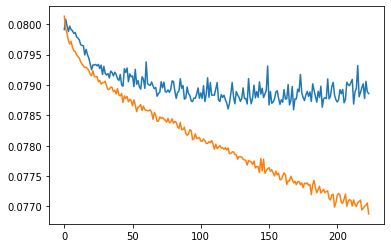

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(history.history['val_loss'][1:])
plt.plot(history.history['loss'][1:])

### lightgbm Model

In [18]:
import lightgbm as lgb
cf = lgb.LGBMRegressor(n_estimators=500)
cf.fit(dataset_train[feature_names].astype(float), dataset_train['rank'])

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=500, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

### Random Forest Model

In [19]:
from sklearn.ensemble import RandomForestRegressor

cf2 = RandomForestRegressor(n_estimators=100)
cf2.fit(dataset_train[feature_names].astype(float), dataset_train['rank'])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

<AxesSubplot:xlabel='Value', ylabel='Feature'>

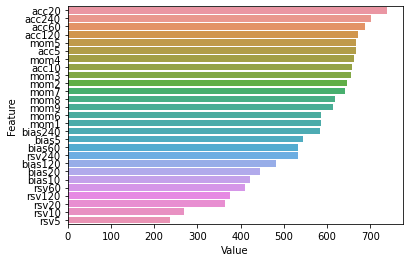

In [20]:
feature_imp = pd.DataFrame(zip(cf.feature_importances_, feature_names), 
                           columns=['Value','Feature']).sort_values('Value', ascending=False)
feature_imp

%matplotlib inline
import seaborn as sns
sns.barplot(x="Value", y="Feature", data=feature_imp)

### Ensemble learning

In [21]:
dataset_drop = dataset.dropna(subset=feature_names+['return'])

vals = model.predict(dataset_drop[feature_names].astype(float))
dataset_drop['result1'] = pd.Series(vals.swapaxes(0,1)[0], dataset_drop.index)

vals = cf.predict(dataset_drop[feature_names].astype(float))
dataset_drop['result2'] = pd.Series(vals, dataset_drop.index)

vals = cf2.predict(dataset_drop[feature_names].astype(float))
dataset_drop['result3'] = pd.Series(vals, dataset_drop.index)

dataset_drop = dataset_drop.reset_index().set_index("date")

C:\Users\Drey\anaconda3\envs\finlab\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\Drey\anaconda3\envs\finlab\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\Drey\anaconda3\envs\finlab\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

# backtest

<AxesSubplot:xlabel='date'>

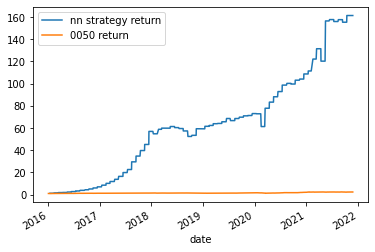

In [22]:
import math


dates = sorted(list(set(dataset_drop.index)))

rs = []
for d in dates:
    
    dataset_time = dataset_drop.loc[d]
    
    dataset_time = drop_extreme_case(dataset_time, 
        ['bias60', 'bias120', 'bias240', 'mom1', 'mom2', 'mom3', 'mom4', 'mom5', 'mom6'], thresh=0.01)
    
    rank = dataset_time['result1'] + dataset_time['result2'] + dataset_time['result3'] 
    
    condition = (rank >= rank.nlargest(20).iloc[-1]) 
    r = dataset_time['return'][condition].mean()

    rs.append(r * (1-3/1000-1.425/1000*2*0.6))

rs = pd.Series(rs, index=dates)['2016':].cumprod()

s0050 = close['0050']['2016':]

pd.DataFrame({'nn strategy return':rs.reindex(s0050.index, method='ffill'), '0050 return':s0050/s0050[0]}).plot()



### 當月持股狀況

In [23]:
dataset.index.levels[1]

DatetimeIndex(['2005-02-15', '2005-03-15', '2005-04-15', '2005-05-15',
               '2005-06-15', '2005-07-15', '2005-08-15', '2005-09-15',
               '2005-10-15', '2005-11-15',
               ...
               '2021-02-15', '2021-03-15', '2021-04-15', '2021-05-15',
               '2021-06-15', '2021-07-15', '2021-08-15', '2021-09-15',
               '2021-10-15', '2021-11-15'],
              dtype='datetime64[ns]', name='date', length=202, freq=None)

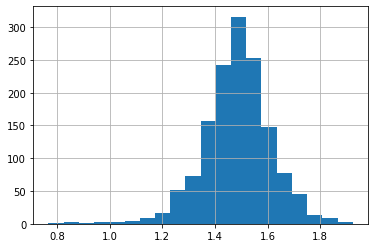

In [24]:
# get the latest dataset
last_date = "2021-10-15"#dataset.index.levels[1].max()
is_last_date = dataset.index.get_level_values('date') == last_date
last_dataset = dataset[is_last_date].copy()


last_dataset = drop_extreme_case(last_dataset, 
    ['bias60', 'bias120', 'bias240', 'mom1', 'mom2', 'mom3', 'mom4', 'mom5', 'mom6'], thresh=0.01)


# remove NaN testcases
last_dataset = last_dataset.dropna(subset=feature_names)

# predict

vals = model.predict(last_dataset[feature_names].astype(float))
last_dataset['result1'] = pd.Series(vals.swapaxes(0,1)[0], last_dataset.index)

vals = cf.predict(last_dataset[feature_names].astype(float))
last_dataset['result2'] = pd.Series(vals, last_dataset.index)

vals = cf2.predict(last_dataset[feature_names].astype(float))
last_dataset['result3'] = pd.Series(vals, last_dataset.index)

# calculate score

rank = last_dataset['result1'] + last_dataset['result2'] + last_dataset['result3']
condition = (rank >= rank.nlargest(20).iloc[-1]) 

# plot rank distribution
rank.hist(bins=20)


# show the best 20 stocks
slist1 = rank[condition].reset_index()['stock_id']

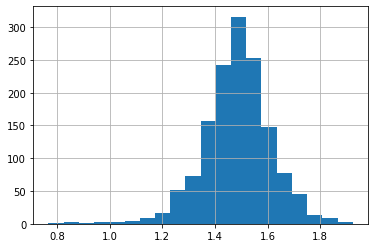

In [25]:
condition1 = (rank >= rank.nlargest(5).iloc[-1]) 

# plot rank distribution
rank.hist(bins=20)


# show the best 20 stocks
slist2 = rank[condition1].reset_index()['stock_id']

In [26]:
slist2

0    2492
1    3521
2    3530
3    5880
4    9917
Name: stock_id, dtype: object

# 平均分配資產於股票之中

In [27]:
close = data.get("收盤價")

money = 1000000
stock_prices = close[rank[condition].reset_index()['stock_id']].iloc[-1]


print("股票平分張數:")
money / len(stock_prices) / stock_prices / 1000


股票平分張數:


stock_id
1303    0.595238
2324    2.136752
2492    0.289017
2540    0.679348
2882    0.830565
2886    1.474926
2890    3.300330
3152    0.136612
3388    0.615764
3521    4.166667
3530    0.362319
4944    2.631579
5434    0.341297
5489    1.447178
5880    2.123142
6166    0.771605
6292    1.190476
6552    0.922509
8435    0.865052
9917    0.492611
Name: 2021-11-26 00:00:00, dtype: float64

In [28]:
stock_prices

stock_id
1303     84.00
2324     23.40
2492    173.00
2540     73.60
2882     60.20
2886     33.90
2890     15.15
3152    366.00
3388     81.20
3521     12.00
3530    138.00
4944     19.00
5434    146.50
5489     34.55
5880     23.55
6166     64.80
6292     42.00
6552     54.20
8435     57.80
9917    101.50
Name: 2021-11-26 00:00:00, dtype: float64